In [1]:
from astropy.table import Table 
import numpy as np 

In [2]:
t = Table.read('pure_grid_fine.csv')

In [3]:
t

sersic_n,sersic_r_eff,sersic_amplitude,sersic_total_flux_99,sersic_r_99,sersic_r_20,sersic_r_80,sersic_c2080,corr_eta,corr_epsilon,corr_r_petrosian,corr_r_half_light,corr_r_total_flux,corr_total_flux,corr_r_20,corr_r_80,corr_c2080,uncorr_eta,uncorr_epsilon,uncorr_r_petrosian,uncorr_r_half_light,uncorr_r_total_flux,uncorr_total_flux,uncorr_r_20,uncorr_r_80,uncorr_c2080
float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
0.2,50,1,17438.474698863196,91.63822310693398,30.88994167338108,66.8579827657041,1.676680903439508,0.2,1.0794390566496688,84.8943,49.72220000000001,91.63822310693398,17264.089951870064,30.8899,66.858,1.6766843927086539,0.2,2,84.8943,50.00000000000001,169.7886,17438.474698863196,31.047,67.39670000000001,1.6830949533623558
0.21000000000000002,50,1,17612.13423326376,92.84891346191357,30.814138624392225,67.14956531076778,1.691465868113927,0.2,1.0862126411819626,85.4795,49.719500000000004,92.84891346191357,17436.0128909284,30.8141,67.1496,1.6914697117514443,0.2,2,85.4795,50.00000000000001,170.959,17612.13423326376,30.9712,67.70200000000001,1.698217328753108
0.22000000000000003,50,1,17787.679337895373,94.06154469555015,30.73559980036752,67.44117909746507,1.706417309380256,0.2,1.093084312249643,86.0515,49.7167,94.06154469555015,17609.802544511065,30.7356,67.44120000000001,1.706417968296333,0.2,2,86.0515,50.00000000000001,172.103,17787.679337895373,30.8926,68.00720000000001,1.7135021661137295
0.23000000000000004,50,1,17964.671384867328,95.27603264141473,30.654656987925723,67.73257955282403,1.7215057741369377,0.2,1.1000479459999761,86.6108,49.7139,95.27603264141473,17785.024671014227,30.654700000000002,67.7326,1.721503382835015,0.2,2,86.6108,50.00000000000001,173.2216,17964.671384867328,30.811600000000002,68.31230000000001,1.728923283186767
0.24000000000000005,50,1,18142.739258968177,96.49232980708376,30.571613887392424,68.02357030137736,1.7367052838650463,0.2,1.1071017307393016,87.1576,49.71110000000001,96.49232980708376,17961.311866374566,30.5716,68.0236,1.7367072183231356,0.2,2,87.1576,50.00000000000001,174.3152,18142.739258968177,30.7285,68.61680000000001,1.7444454983168205
0.25000000000000006,50,1,18321.568667379608,97.71041704871264,30.48674702166199,68.31399385678677,1.7519929466186919,0.2,1.1142404250392581,87.6924,49.70830000000001,97.71041704871264,18138.35298070333,30.486700000000003,68.31400000000001,1.7519964910943167,0.2,2,87.6924,50.00000000000001,175.3848,18321.568667379604,30.643600000000003,68.9208,1.7600526257996465
0.26000000000000006,50,1,18500.893190373583,98.93029711712362,30.400307141002138,68.6037242447284,1.7673486059924584,0.2,1.1214641577722189,88.2153,49.70550000000001,98.93029711712362,18315.88425846939,30.4003,68.6037,1.7673483486653063,0.2,2,88.2153,50.00000000000001,176.4306,18500.89319037353,30.5572,69.224,1.775715670027854
0.2700000000000001,50,1,18680.48680268622,100.1519896338712,30.312520905252917,68.89266112520717,1.7827545258057174,0.2,1.1287669199968802,88.7269,49.70270000000001,100.15198963387118,18493.681934657925,30.3125,68.8927,1.7827572486975762,0.2,2,88.7269,50.00000000000001,177.4538,18680.4868026853,30.4694,69.52640000000001,1.7914292022584042
0.2800000000000001,50,1,18860.15762592694,101.37552716573907,30.223592692744838,69.18072508532416,1.7981951084713177,0.2,1.136147945202248,89.2274,49.6998,101.37552716573907,18671.556049664803,30.2236,69.1807,1.7981937960791348,0.2,2,89.2274,50.00000000000001,178.4548,18860.157625916738,30.3805,69.8279,1.8071703205997582


In [4]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})


import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

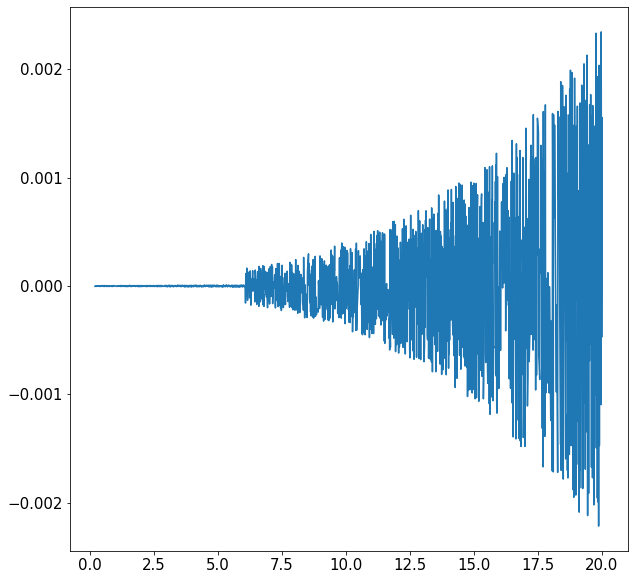

In [23]:
plt.plot(t['sersic_n'],t['sersic_c2080']- t['corr_c2080'])

In [21]:
np.any(100*abs(t['sersic_c2080'] - t['corr_c2080'])/t['sersic_c2080'] > 0.01)

True

In [2]:
import multiprocessing as mp
import numpy as np 
from scipy.special import gammaincinv, gamma, factorial, lambertw

from astropy.modeling import models 
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.modeling import custom_model, powerlaws, functional_models
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve

from petrofit.models import sersic_enclosed, sersic_enclosed_inv, petrosian_profile, sersic_enclosed, make_grid, PSFModel
from petrofit.petrosian import Petrosian, PetrosianCorrection, calculate_petrosian,discrete_petrosian_r
from petrofit.fitting import model_to_image, fit_model
from petrofit.photometry import calculate_photometic_density,  make_radius_list
from petrofit.petrosian import Petrosian
from petrofit.utils import closest_value_index, get_interpolated_values
from scipy.interpolate import interp1d
from petrofit.petrosian import fraction_flux_to_r

%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})


import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

In [3]:
import multiprocessing as mp
from multiprocessing import Pool, cpu_count

In [37]:
delta = 20
r_eff_list = [50]#np.arange(delta, 100 + delta, delta)
delta = 0.01
n_list = np.arange(0.02, 20 + delta, delta)

# delta = 0.5
# n_list = np.arange(0.5, 20 + delta, delta)

names = [
    "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_r_50", "sersic_r_90", "sersic_c2080", "sersic_c5090", "sersic_petro_0502",
    "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_r_50", "corr_r_90", "corr_c2080", "corr_c5090",
    'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80',  "uncorr_r_50", "uncorr_r_90", "uncorr_c2080", "uncorr_c5090",
]

def process_image(n):
    rows = []
    n = np.round(n, 4)
    #with ProgressBar(len(r_eff_list), ipython_widget=True) as bar:
    if True:
        for r_eff_idx, r_eff in enumerate(r_eff_list):
            
            b_n = gammaincinv(2. * n, 0.5)
            amplitude=1 #/np.exp(b_n)

            total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
            enclosed_99 = total_flux*.99

            r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
            r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
            r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)
            r_90 = sersic_enclosed_inv(enclosed_99*0.9, amplitude, r_eff, n)
            r_50 = sersic_enclosed_inv(enclosed_99*0.5, amplitude, r_eff, n)

            oversample = 10000
            compute_r_cutoff = 2000

            if r_99 > compute_r_cutoff: 
                max_pix=int(r_90)*oversample
            else:
                max_pix=int(r_99*2)*oversample

            r_list = make_radius_list(
                        max_pix=max_pix, # Max pixel to go up to
                        n=max_pix,# the number of radii to produce
            )
            r_list /=oversample

            if r_99 > compute_r_cutoff: 
                delta = ((3*r_99)-r_90)
                if delta > 1000:
                    delta /= 1000
                else:
                    delta = 1

                r_list = list(r_list) + list(np.arange(r_90+delta, (3*r_99)+delta, delta))
                r_list = np.array(r_list)

            flux_arr = sersic_enclosed(r_list, amplitude, r_eff, n)
            #area_arr = np.pi*(r_list**2)

            petrosian_list = petrosian_profile(r_list, r_eff, n)

            # Interpolate values

            eta = 0.2 
            idx = closest_value_index(eta, petrosian_list)
            r_petrosian = r_list[idx]

            idx = closest_value_index(0.2, petrosian_list)
            r_pertro_02 = r_list[idx]

            idx = closest_value_index(0.5, petrosian_list)
            r_pertro_05 = r_list[idx]

            c_petro_0502 = 5 * np.log10(r_pertro_02/r_pertro_05)
            
            #r_list_new, petrosian_list_new = get_interpolated_values(r_list, petrosian_list, num=len(r_list)*10, kind='linear')
            #idx = closest_value_index(eta, petrosian_list_new)
            #r_petrosian = r_list_new[idx]

            #f = interp1d(petrosian_list, r_list, kind='linear')
            #r_petrosian = f(eta)

            idx_list = np.where(petrosian_list <= eta)[0]

            #print(total_flux)
            epsilon = r_99 / r_petrosian
            p_corr = None#Petrosian(r_list, area_arr, flux_arr, epsilon=epsilon)

            p_corr_eta = eta
            p_corr_epsilon = epsilon
            p_corr_r_petrosian = r_petrosian
            p_corr_r_total_flux = r_petrosian * p_corr_epsilon
            f = interp1d(r_list, flux_arr, kind='linear')
            p_corr_total_flux = f(p_corr_r_total_flux)
            p_corr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.2)
            p_corr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.8)
            p_corr_r_50 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)
            p_corr_r_90 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.9)
            p_corr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)


            p_uncorr_eta = eta
            p_uncorr_epsilon = 2
            p_uncorr_r_petrosian = r_petrosian
            p_uncorr_r_total_flux = r_petrosian * p_uncorr_epsilon
            f = interp1d(r_list, flux_arr, kind='linear')
            p_uncorr_total_flux = f(p_uncorr_r_total_flux)
            p_uncorr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.2)
            p_uncorr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.8)
            p_uncorr_r_50 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)
            p_uncorr_r_90 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.9)
            p_uncorr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)

            row = [
                n, r_eff, amplitude, total_flux, r_99, r_20, r_80, r_50, r_90, 5 *np.log10(r_80 / r_20), 5 *np.log10(r_90 / r_50), c_petro_0502,
                p_corr_eta, p_corr_epsilon, p_corr_r_petrosian, p_corr_r_half_light, p_corr_r_total_flux, p_corr_total_flux, p_corr_r_20, p_corr_r_80, p_corr_r_50, p_corr_r_90, 5 *np.log10(p_corr_r_80 / p_corr_r_20), 5 *np.log10(p_corr_r_90 / p_corr_r_50), 
                p_uncorr_eta, p_uncorr_epsilon, p_uncorr_r_petrosian, p_uncorr_r_half_light, p_uncorr_r_total_flux, p_uncorr_total_flux, p_uncorr_r_20, p_uncorr_r_80, p_uncorr_r_50, p_uncorr_r_90, 5 *np.log10(p_uncorr_r_80 / p_uncorr_r_20), 5 *np.log10(p_uncorr_r_90 / p_uncorr_r_50),
            ]
            assert not np.any(np.isnan(np.array(row))), "{}".format(n)
            #plt.plot(r_list, petrosian_list)
            #plt.show()
            del petrosian_list
            del flux_arr
            del r_list
            
            rows.append(row)
            #bar.update()
            
    #print("done")
    print(n)
    return Table(rows=rows, names=names)
    


# t = Table(rows=rows, names=names)

# plt.show()


In [ ]:
# Start multiprocessing photometry (a core per filter)
if __name__ == '__main__':
    with Pool(processes=5) as pool: 
        print("Starting MP")
        try:
            grid_tables = pool.map(process_image, list(n_list))
        except Exception as e:
            pool.close()
            raise e 
            
    print("Done")

Starting MP
0.36
0.7
1.04
0.37
1.38
0.71
1.72
0.38
2.06
1.05
0.72
0.39
2.4
1.39
2.74
0.4
1.06
0.73
3.08
1.73
0.41
2.07
3.42
0.74
1.4
0.42
1.07
3.76
0.43
0.75
2.41
1.74
4.1
1.08
0.44
1.41
6.14
2.75
0.76
4.44
2.08
0.45
1.09
0.77
4.78
3.09
6.15
1.75
0.46
1.42
2.42
0.47
0.78
1.1
6.16
3.43
0.48
2.09
1.43
0.79
1.76
2.76
1.11
0.49
6.17
3.77
0.8
0.5
1.44
2.43
6.18
1.12
3.1
0.51
0.81
1.77
2.1
4.11
0.52
6.19
1.13
0.82
1.45
0.53
2.77
4.45
0.83
1.78
3.44
6.2
1.14
0.54
2.44
2.11
1.46
0.84
0.55
6.21
4.79
1.15
3.11
0.56
1.79
3.78
0.85
6.22
1.47
0.57
2.12
2.78
1.16
2.45
0.86
6.23
0.58
1.8
1.48
4.12
0.87
1.17
0.59
3.45
6.24
0.6
2.13
0.88
1.18
1.49
3.12
6.25
1.81
0.61
2.46
2.79


In [25]:
from astropy.table import vstack

In [33]:
t = vstack(grid_tables)

In [36]:
t.write('fine_petro_table_no_psf.csv', overwrite=True)

In [86]:
process_image(1)

1


sersic_n,sersic_r_eff,sersic_amplitude,sersic_total_flux_99,sersic_r_99,sersic_r_20,sersic_r_80,sersic_c2080,sersic_petro_0205,corr_eta,corr_epsilon,corr_r_petrosian,corr_r_half_light,corr_r_total_flux,corr_total_flux,corr_r_20,corr_r_80,corr_c2080,uncorr_eta,uncorr_epsilon,uncorr_r_petrosian,uncorr_r_half_light,uncorr_r_total_flux,uncorr_total_flux,uncorr_r_20,uncorr_r_80,uncorr_c2080
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1,50,1,29871.236853659997,197.76458942879003,24.39461142123563,87.64198561276176,2.7770915183788345,1.5267230021872105,0.2,1.8325959266903584,107.915,49.52610000000001,197.76458942879003,29572.52448512328,24.3946,87.64200000000001,2.777092891500987,0.2,2,107.915,49.72070000000001,215.83,29695.414232465737,24.462500000000002,88.27810000000001,2.7867606932548936


In [87]:
r_pertro_05, r_pertro_02, r_pertro_05 / r_pertro_02, c_petro_0205

In [91]:
t.colnames.index('sersic_petro_0205')

8

In [93]:
t.colnames[8] = 'sersic_petro_0502'

In [96]:
t.rename_column('sersic_petro_0205', 'sersic_petro_0502')

In [34]:
t

sersic_n,sersic_r_eff,sersic_amplitude,sersic_total_flux_99,sersic_r_99,sersic_r_20,sersic_r_80,sersic_r_50,sersic_r_90,sersic_c2080,sersic_c5090,sersic_petro_0502,corr_eta,corr_epsilon,corr_r_petrosian,corr_r_half_light,corr_r_total_flux,corr_total_flux,corr_r_20,corr_r_80,corr_r_50,corr_r_90,corr_c2080,corr_c5090,uncorr_eta,uncorr_epsilon,uncorr_r_petrosian,uncorr_r_half_light,uncorr_r_total_flux,uncorr_total_flux,uncorr_r_20,uncorr_r_80,uncorr_r_50,uncorr_r_90,uncorr_c2080,uncorr_c5090
float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.02,50,1,15707.963528967697,71.40516830043747,31.464265434647732,62.93059555384164,49.749371851657564,66.78837319393094,1.505221223141862,0.6395663180461293,0.0363436477752976,0.2,0.9888638762657644,72.2093,49.74937185165756,71.40516830043747,15550.883893678014,31.46426543464772,62.93059555384162,49.74937185165756,66.78837319393094,1.505221223141862,0.6395663180461297,0.2,2,72.2093,49.74937185165756,144.4186,15550.883893678014,31.46426543464772,62.93059555384162,49.74937185165756,66.78837319393094,1.505221223141862,0.6395663180461297
0.03,50,1,15708.047175054557,72.2551772778192,31.46426040295366,62.950235415439636,49.7493706257674,66.91953762642379,1.5058991543900548,0.6438267034354574,0.05433778215930992,0.2,0.9902622366100675,72.9657,49.7493706257674,72.2551772778192,15550.966703304013,31.464260402953652,62.950235415439636,49.7493706257674,66.91953762642379,1.5058991543900553,0.6438267034354574,0.2,2,72.9657,49.7493706257674,145.9314,15550.966703304013,31.464260402953652,62.950235415439636,49.7493706257674,66.91953762642379,1.5058991543900553,0.6438267034354574
0.04,50,1,15709.465445009302,73.19186495159643,31.46414509612959,63.00569596523017,49.74934938853548,67.13679713322007,1.5078193851518464,0.6508660659775783,0.07221964368253292,0.2,0.9927470540021706,73.7266,49.74934938853548,73.19186495159643,15552.37079055921,31.46414509612959,63.00569596523017,49.74934938853548,67.13679713322007,1.5078193851518464,0.6508660659775783,0.2,2,73.7266,49.74934938853548,147.4532,15552.37079055921,31.46414509612959,63.00569596523017,49.74934938853548,67.13679713322007,1.5078193851518464,0.6508660659775783
0.05,50,1,15716.439267926888,74.1911342106297,31.463416981643544,63.10308651247255,49.74924351878205,67.42440748041399,1.5112235804570961,0.6601532865030911,0.08999417782933855,0.2,0.9959731325034762,74.4911,49.74924351878205,74.1911342106297,15559.274875247616,31.463416981643537,63.10308651247254,49.74924351878205,67.42440748041398,1.5112235804570961,0.6601532865030907,0.2,2,74.4911,49.74924351878205,148.9822,15559.274875247616,31.463416981643537,63.10308651247254,49.74924351878205,67.42440748041398,1.5112235804570961,0.6601532865030907
0.06,50,1,15734.83617139153,75.23813078580307,31.461041546469026,63.240135600013595,49.74896162694044,67.76756106372022,1.5160984811940974,0.6711891765451126,0.10766356884316473,0.2,0.9997545834624878,75.2566,49.74896162694044,75.23813078580307,15577.487809677614,31.461041546469026,63.240135600013595,49.74896162694044,67.76756106372022,1.5160984811940974,0.6711891765451126,0.2,2,75.2566,49.74896162694044,150.5132,15577.487809677614,31.461041546469026,63.240135600013595,49.74896162694044,67.76756106372022,1.5160984811940974,0.6711891765451126
0.07,50,1,15769.31121006319,76.32197020211765,31.455701781583027,63.41125854727115,49.74842990338771,68.15384485463343,1.5223349703664284,0.6835549132640346,0.12523339778541492,0.2,1.0039735674753274,76.0199,49.74842990338771,76.32197020211765,15611.618097962555,31.455701781583027,63.411258547271146,49.74842990338771,68.15384485463345,1.522334970366428,0.6835549132640351,0.2,2,76.0199,49.74842990338771,152.0398,15611.618097962555,31.455701781583027,63.411258547271146,49.74842990338771,68.15384485463345,1

In [ ]:
len(np.arange(0.5,5.5,0.5))

In [105]:
len(np.arange(10,101,10))

10

# Second Simulation 

PSF Shape = (51, 51)


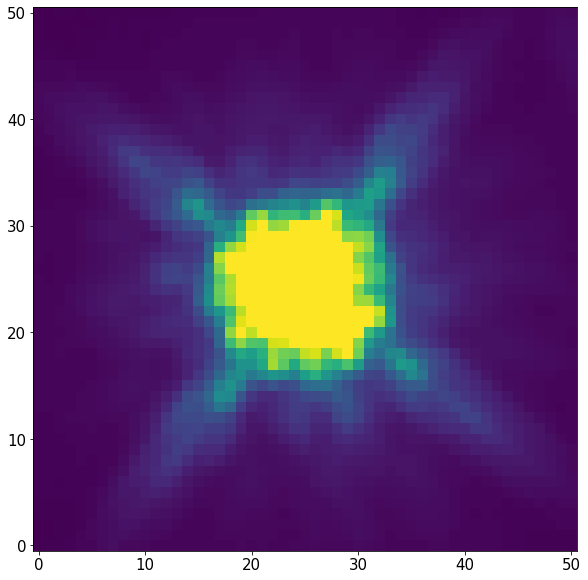

In [108]:
from astropy.io import fits

from matplotlib import pyplot as plt

# Load PSF image (2D array)
PSF = fits.getdata('data/f105w_psf.fits.gz')

# Normalize PSF 
PSF = PSF / PSF.sum()

# Note that the PSF shape is odd on all sides
print("PSF Shape = {}".format(PSF.shape))

# Plot PSF and use vmax and vmin to show difraction spikes
plt.imshow(PSF, vmin=0, vmax=5e-4)
plt.show()

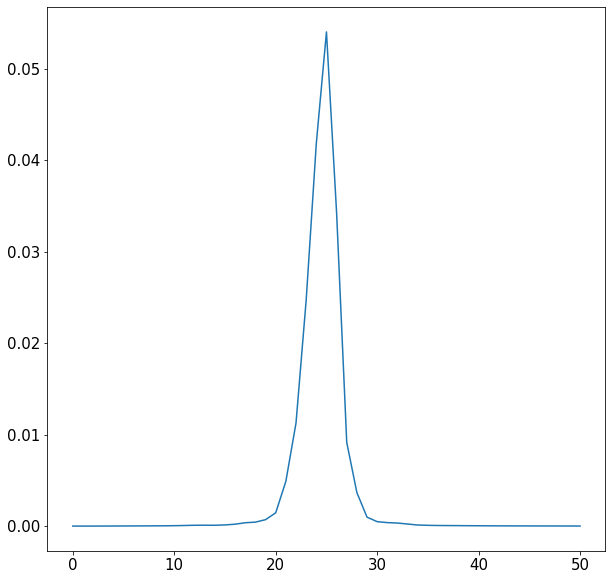

In [110]:
PSF_SLICE = PSF[PSF.shape[0]//2, :]

plt.plot(PSF_SLICE)

In [ ]:
run = 0

delta = 20
r_eff_list = [50]#np.arange(delta, 100 + delta, delta)
delta = 0.01
n_list = np.arange(0.2, 20 + delta, delta)

names = [
    "sersic_n", "sersic_r_eff", "sersic_amplitude", "sersic_total_flux_99", "sersic_r_99", "sersic_r_20", "sersic_r_80", "sersic_c2080", "sersic_petro_0502",
    "corr_eta", "corr_epsilon", "corr_r_petrosian", "corr_r_half_light", "corr_r_total_flux", "corr_total_flux", "corr_r_20", "corr_r_80", "corr_c2080",
    'uncorr_eta', 'uncorr_epsilon', 'uncorr_r_petrosian', 'uncorr_r_half_light', 'uncorr_r_total_flux', 'uncorr_total_flux', 'uncorr_r_20', 'uncorr_r_80', 'uncorr_c2080'
]

def process_image_2(n):
    rows = []
    #with ProgressBar(len(r_eff_list), ipython_widget=True) as bar:
    if True:
        for r_eff_idx, r_eff in enumerate(r_eff_list):
            
            b_n = gammaincinv(2. * n, 0.5)
            amplitude=1 #/np.exp(b_n)

            total_flux = sersic_enclosed(np.inf, amplitude, r_eff, n)
            enclosed_99 = total_flux*.99

            r_99 = sersic_enclosed_inv(enclosed_99, amplitude, r_eff, n)
            r_20 = sersic_enclosed_inv(enclosed_99*0.2, amplitude, r_eff, n)
            r_80 = sersic_enclosed_inv(enclosed_99*0.8, amplitude, r_eff, n)
            r_90 = sersic_enclosed_inv(enclosed_99*0.9, amplitude, r_eff, n)
            r_50 = sersic_enclosed_inv(enclosed_99*0.5, amplitude, r_eff, n)

            oversample = 10000
            compute_r_cutoff = 2000

            if r_99 > compute_r_cutoff: 
                max_pix=int(r_90)*oversample
            else:
                max_pix=int(r_99*2)*oversample

            r_list = make_radius_list(
                        max_pix=max_pix, # Max pixel to go up to
                        n=max_pix,# the number of radii to produce
            )
            r_list /=oversample

            if r_99 > compute_r_cutoff: 
                delta = ((3*r_99)-r_90)
                if delta > 1000:
                    delta /= 1000
                else:
                    delta = 1

                r_list = list(r_list) + list(np.arange(r_90+delta, (3*r_99)+delta, delta))
                r_list = np.array(r_list)

            flux_arr = sersic_enclosed(r_list, amplitude, r_eff, n)
            area_arr = np.pi*(r_list**2)

            #petrosian_list = petrosian_profile(r_list, r_eff, n)
            
            # Interpolate values

            eta = 0.2 
            idx = closest_value_index(eta, petrosian_list)
            r_petrosian = r_list[idx]

            idx = closest_value_index(0.2, petrosian_list)
            r_pertro_02 = r_list[idx]

            idx = closest_value_index(0.5, petrosian_list)
            r_pertro_05 = r_list[idx]

            c_petro_0502 = 5 * np.log10(r_pertro_02/r_pertro_05)
            
            #r_list_new, petrosian_list_new = get_interpolated_values(r_list, petrosian_list, num=len(r_list)*10, kind='linear')
            #idx = closest_value_index(eta, petrosian_list_new)
            #r_petrosian = r_list_new[idx]

            #f = interp1d(petrosian_list, r_list, kind='linear')
            #r_petrosian = f(eta)

            idx_list = np.where(petrosian_list <= eta)[0]

            #print(total_flux)
            epsilon = r_99 / r_petrosian
            p_corr = None#Petrosian(r_list, area_arr, flux_arr, epsilon=epsilon)

            p_corr_eta = eta
            p_corr_epsilon = epsilon
            p_corr_r_petrosian = r_petrosian
            p_corr_r_total_flux = r_petrosian * p_corr_epsilon
            f = interp1d(r_list, flux_arr, kind='linear')
            p_corr_total_flux = f(p_corr_r_total_flux)
            p_corr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.2)
            p_corr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.8)
            p_corr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_corr_r_total_flux, fraction=0.5)


            p_uncorr_eta = eta
            p_uncorr_epsilon = 2
            p_uncorr_r_petrosian = r_petrosian
            p_uncorr_r_total_flux = r_petrosian * p_uncorr_epsilon
            f = interp1d(r_list, flux_arr, kind='linear')
            p_uncorr_total_flux = f(p_uncorr_r_total_flux)
            p_uncorr_r_20 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.2)
            p_uncorr_r_80 = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.8)
            p_uncorr_r_half_light = fraction_flux_to_r(r_list, flux_arr, p_uncorr_r_total_flux, fraction=0.5)

            row = [
                n, r_eff, amplitude, total_flux, r_99, r_20, r_80, 5 *np.log10(r_80 / r_20), c_petro_0502,
                p_corr_eta, p_corr_epsilon, p_corr_r_petrosian, p_corr_r_half_light, p_corr_r_total_flux, p_corr_total_flux, p_corr_r_20, p_corr_r_80, 5 *np.log10(p_corr_r_80 / p_corr_r_20), 
                p_uncorr_eta, p_uncorr_epsilon, p_uncorr_r_petrosian, p_uncorr_r_half_light, p_uncorr_r_total_flux, p_uncorr_total_flux, p_uncorr_r_20, p_uncorr_r_80, 5 *np.log10(p_uncorr_r_80 / p_uncorr_r_20),
            ]
            assert not np.any(np.isnan(np.array(row))), "{}".format(n)
            #plt.plot(r_list, petrosian_list)
            #plt.show()
            del petrosian_list
            del flux_arr
            del r_list
            
            rows.append(row)
            #bar.update()
            
    #print("done")
    print(n)
    return Table(rows=rows, names=names)
    


# t = Table(rows=rows, names=names)

# plt.show()
